In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('/content/car_price.csv')

 Data Preparation

 Keep only the columns above

 Lowercase the column names and replace spaces with underscores
 Fill the missing values with 0


 Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

 Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
variables =  ['Make', 'Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP'  ]

In [4]:
df = df[variables]

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df.fillna(0, inplace=True)

In [7]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(include=['number']).columns.tolist()

In [8]:
numerical = [x for x in numerical if x != 'msrp']

In [9]:
df['above_average'] = np.where(df.msrp > df.msrp.mean(),1,0)
df = df.drop('msrp', axis=1)

In [10]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [11]:

y_train = df_train.above_average
y_val = df_val.above_average

del df_train['above_average']
del df_val['above_average']


df_train.shape[0]/df.shape[0]

0.5999664260533826

# Question 1: ROC AUC feature importance

Which numerical variable (among the following 4) has the highest AUC?


In [12]:
for x in numerical:
    auc = roc_auc_score(y_train, df_train[x])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[x])
    print("\nNumerical variable :", x)
    print("AUC score:", auc)


Numerical variable : year
AUC score: 0.687551492804683

Numerical variable : engine_hp
AUC score: 0.9171031265539011

Numerical variable : engine_cylinders
AUC score: 0.766116490165669

Numerical variable : highway_mpg
AUC score: 0.6330587871772013

Numerical variable : city_mpg
AUC score: 0.6734244643245233


#Question 2: Training the model

 Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:


 LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


 What's the AUC of this model on the validation dataset? (round to 3 digits)

In [13]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [14]:
score = roc_auc_score(y_val, y_pred).round(3)
print("AUC on the validation dataset:", score)

AUC on the validation dataset: 0.98


In [18]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [22]:
auc(fpr, tpr).round(3)

0.98

#Question 3: Precision and Recall

Now let's compute precision and recall for our model.

 Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

 For each threshold, compute precision and recall and plot them

 At which threshold precision and recall curves intersect?

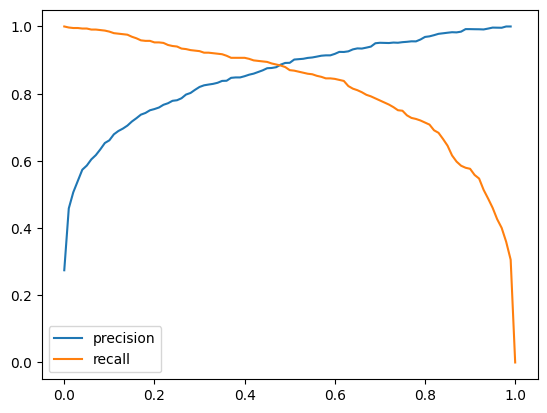

In [24]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

In [25]:
df_scores.iloc[48]

threshold       0.480000
tp            578.000000
fp             74.000000
fn             76.000000
tn           1655.000000
precision       0.886503
recall          0.883792
Name: 48, dtype: float64

#Question 4: F1 score

 Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
 This is the formula for computing F1:

 F1 = 2(P.R)/(P+R)

 Where is P precision and R is recall.
 Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

 At which threshold F1 is maximal?

In [26]:
df_scores['f1'] = ((2 * df_scores['recall'] * df_scores['precision']) / (df_scores['recall'] + df_scores['precision']))

In [27]:
df_scores['f1'].max()

0.8852963818321786

In [28]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
49,0.49,575,70,79,1659,0.891473,0.879205,0.885296


The nearest option is 0.52


#Question 5: 5-Fold CV
 Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
 Iterate over different folds of df_full_train
 Split the data into train and validation
 Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
 Use AUC to evaluate the model on validation

 How large is standard deviation of the scores across different folds?

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)

auc_scores = []

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

dv = DictVectorizer(sparse=False)

In [54]:
for train_idx, val_idx in kf.split(df_train_full):

    df_train_fold = df_train_full.iloc[train_idx]
    df_val_fold = df_train_full.iloc[val_idx]

    y_train_fold = df_train_fold['above_average']
    y_val_fold = df_val_fold['above_average']


    del df_train_fold["above_average"]
    del df_val_fold["above_average"]

    train_dicts = df_train_fold.to_dict(orient='records')
    val_dicts = df_val_fold.to_dict(orient='records')

    X_train_fold = dv.fit_transform(train_dicts)
    X_val_fold = dv.transform(val_dicts)

    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc_fold)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [38]:
auc_scores

[0.9828366287115824,
 0.9722049199388745,
 0.9734577643106146,
 0.9845053142454313,
 0.9777868351334829]

In [39]:
print("Standard Deviation of AUC Scores:", np.std(auc_scores))

Standard Deviation of AUC Scores: 0.004895857543505324


#Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [52]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values



        dicts = df_train[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)

        model = LogisticRegression(C=C, max_iter=1000)
        model.fit(X_train, y_train)


        dicts = df_val[categorical + numerical].to_dict(orient="records")

        X = dv.transform(dicts)
        y_pred = model.predict_proba(X)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('\nC=%s %.3f +- %.3f\n' % (C, np.mean(scores), np.std(scores)))


C=0.01 0.952 +- 0.002


C=0.1 0.972 +- 0.002



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


C=0.5 0.979 +- 0.003



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


C=10 0.980 +- 0.003



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 BEST FOR C=10 0.980 +- 0.003